[Jupyter Book](https://geo-smart.github.io/oceanography/intro.html) and [GitHub repo](https://github.com/geo-smart/oceanography).


# Epipelargosy




> Wavering between the profit and the loss
in this brief transit where the dreams cross... <br><br>-T.S.Eliot


**Epipelargosy (επιπελαργοση)(noun): A neologism intended to evoke a voyage through the epipelagic zone.**


This notebook introduces physical and bio-optical data from a 
Shallow Profiler, pictured below. 
The profiler base or *platform* is anchored to the sea floor by cables. 
The platform is
positively buoyant and therefore *'floats'* at a depth of 200 meters below the ocean surface.
By means of a cable: A sensor pod is regularly released upward 
from this platform to a few meters depth
and then drawn back down to the platform by means of a winch.
The sensors thereby *see* or *observe* the water column from a depth range of 
10 to 200 meters, usually nine times each day, hence 'shallow profiler'.





```{figure} ../img/shallowprofilerinsitu.png
---
height: 500px
name: directive-fig
---
Shallow Profiler: Platform and Science Pod photographed by ROV; depth 200 meters.
The orange sensor pod (the Science Pod or SCIP) is connected to the rectangular platform
by means of the yellow cable.
Multiple *instruments* are visible attached to the SCIP, each bearing
one or more *sensors*. Sensors correspond to types of data: Temperature, 
salinity, chlorophyll fluorescence and so on. 
```

The shallow profiler platform resides at a site (i.e. a geographic location).
Sites are in turn wired together by means of cables resting on the sea floor.
The result is an enormous undersea observatory called the Regional Cabled Array (RCA). 
The RCA is one of several arrays making up the Ocean Observatories Initiative.

### Technical note

The `shallowprofiler_techical.ipynb` notebook goes to some length to sort out the data dictionary for sensors
and profile metadata use. 

## Load profile metadata and build the data dictionary


The next step is to build a data dictionary **`d `** with keys corresponding to sensors:
**`conductivity`, `temperature`, `pco2`** etcetera. Those sensor names are the dictionary
keys. What are the dictionary values? They are five-tuples indexed like so: \[0\], \[1\], ..., \[4\].
These correspond to two XArray data arrays, 2 floats, and one string:


```
0: XArray DataArray: sensor data
1: XArray DataArray: sensor depth (meters, negative down) corresponding to data
2: float: Default charting lower limit for data
3: float: Default charting upper limit for data
4: string: Default chart color e.g. "blue"
```

Note that if the time extent of the data is one month -- say 30 days -- 
a healthy shallow profiler will generate about $9 \times 30 = 270$ profiles.
Selecting out time blocks that correspond to these profiles is done using
the profile metadata, contained in the dataframe called `profiles`. 

In [1]:
from matplotlib import pyplot as plt
from shallowprofiler import *
from data import *
from charts import *
from os import path


# This cell loads data versus depth from local files into a dictionary d{}. To stage the 
#   data if it is not present: See the Data Loader chapter. Each of the more than 12 sensor
#   types is a dictionary key; where the value is a 5-tuple as described above.

def GetSensorTuple(s, f):
    '''
    s is the sensor identifier string like 'temperature'
    f is the source filename like './../data/osb_ctd_jan22_temperature.nc' 
    '''
    DA_sensor    = xr.open_dataset(f)[s]                # DataArray
    DA_depth     = xr.open_dataset(f)['depth']          # DataArray
    range_lo     = ranges[s][0]                         # expected numerical range of this sensor data
    range_hi     = ranges[s][1]                         #   lo and high
    sensor_color = colors[s]                            #   default chart color for this sensor
    return (DA_sensor, DA_depth, range_lo, range_hi, sensor_color)


profiles = ReadProfileMetadata()


d = {}                # d is an empty dictionary that will be populated with 5-tuples based on 
                      # what data files are resident in the base path. Default is January 2022,
                      # Oregon Slope Base

data_file_root_path   = './data/rca/sensors'
sitestring            = 'osb'
monthstring           = 'jan'               
yearstring            = '2022'

for sensor in sensors:          # sensor is a list of 2 strings [sensor_str, instrument_str]
    f = AssembleDataFilename(data_file_root_path, sitestring, sensor[0], monthstring, yearstring)
    if path.isfile(f):
        d[sensor[0]] = GetSensorTuple(sensor[0], f)    # creates the dictionary d{} entry for this sensor



Jupyter Notebook running Python 3


In [2]:
# Start with CTD temperature and salinity
how_many_charts = 1

# quick check: use d['temperature'].z.plot()
profile_list = [n for n in range(how_many_charts)]

In [3]:
d.keys()

dict_keys(['conductivity', 'density', 'salinity', 'temp', 'chlora', 'backscatter', 'fdom', 'nitrate', 'pco2', 'do', 'ph', 'up', 'east', 'north'])

### Using ChartTwoSensors()


The fossil code below illustrates some aspects of the data dictionary d{}:
- d{} has a key (in this case 'ph') that is the name of a sensor. 
    - The full list of sensor names is given in the Data chapter.
- d[key] has a value: A 5-element tuple
    - The first two elements of this tuple are XArray DataFrames
        - d[key][0] is sensor data as a function of time
        - d[key][1] is depth as a function of time
    - Elements [2] and [3] are the expected numerical range of the sensor data
    - Element [4] is a string: Default plot color for this sensor

```
Data dictionary values
    [0] DataArray: sensor data values, dimension = 'time'  
    [1] DataArray: sensor depths z,    dimension = 'time'    
    [2] low-end expected data range                         
    [3] high-end expected data range                      
    [4] color for this sensor                             

print(d['ph'][0], d['ph'][1])
for a in list(d['ph'][0].attrs.keys()): del d['ph'][0].attrs[a]
for a in list(d['ph'][1].attrs.keys()): del d['ph'][1].attrs[a]
print(d['ph'][0], d['ph'][1])
```

Profile data from two sensors can be compared on a single chart using ChartTwoSensors(). 
The function arguments relate to the data dictionary d{}.

In [4]:
# The sensors data structure is a list of lists. Each element is the list ['<sensor-name>', '<instrument-name>'].
sensors

[['conductivity', 'ctd'],
 ['density', 'ctd'],
 ['pressure', 'ctd'],
 ['salinity', 'ctd'],
 ['temp', 'ctd'],
 ['chlora', 'fluor'],
 ['backscatter', 'fluor'],
 ['fdom', 'fluor'],
 ['spkir412nm', 'spkir'],
 ['spkir443nm', 'spkir'],
 ['spkir490nm', 'spkir'],
 ['spkir510nm', 'spkir'],
 ['spkir555nm', 'spkir'],
 ['spkir620nm', 'spkir'],
 ['spkir683nm', 'spkir'],
 ['nitrate', 'nitrate'],
 ['pco2', 'pco2'],
 ['do', 'do'],
 ['par', 'par'],
 ['ph', 'ph'],
 ['up', 'vel'],
 ['east', 'vel'],
 ['north', 'vel']]

Attempting 1 charts



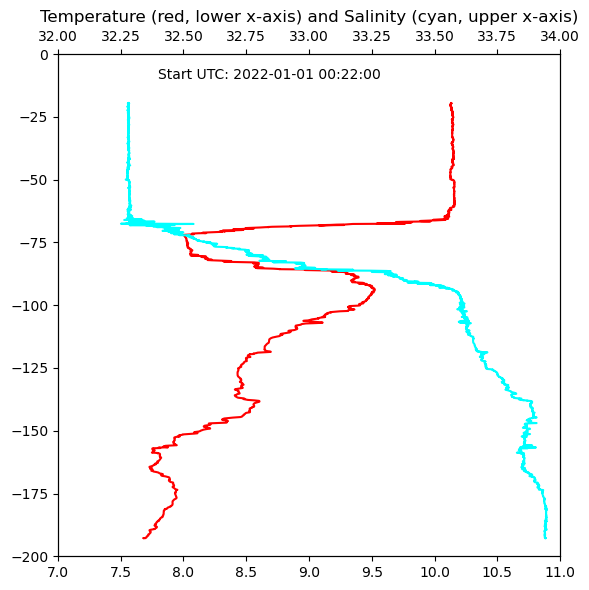

In [5]:
# temperature and salinity
fig,axs = ChartTwoSensors(profiles, [ranges['temp'], ranges['salinity']], profile_list, 
                          d['temp'][0],     -d['temp'][1],     'Temperature', colors['temp'],     'ascent',
                          d['salinity'][0], -d['salinity'][1], 'Salinity',    colors['salinity'], 'ascent', 6, 6)

Interpretation: The upper 70m is a homogeneous *mixed layer*. The transitional section below this
(particularly in terms of salinity) from 70m to 95m represents a sharp change in temperature and salinity.
This is the *pycnocline*, a boundary separating the mixed layer from the lower ocean. From 95m down
to the lowest observed depth of 195m we have water that is colder, more saline, and more dense. The cold
temperature excursion in the data in the 70--90m depth range is an anomalous departure from a monotonic 
gradient. 

Attempting 1 charts



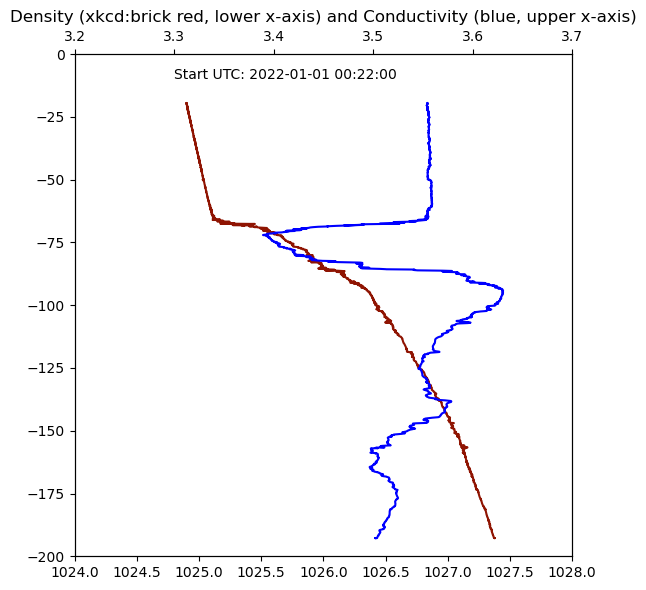

In [6]:
# density and pressure
fig,axs = ChartTwoSensors(profiles, [ranges['density'], ranges['conductivity']], profile_list, 
                          d['density'][0],      -d['density'][1],      'Density',      colors['density'],    'ascent',
                          d['conductivity'][0], -d['conductivity'][1], 'Conductivity', 'blue', 'ascent', 6, 6)

Interpretation: ...hmmmm... compared to the one prior: It seems like conductivity and salinity are not 'pretty much the same thing'...

Attempting 1 charts



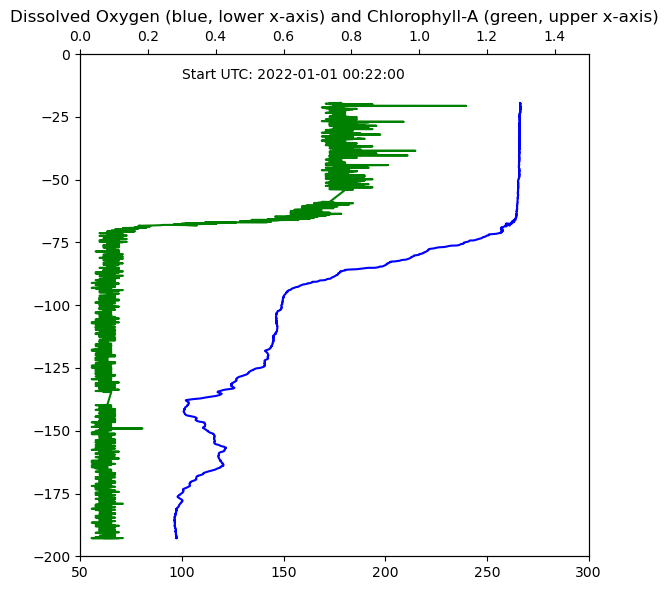

In [7]:
# dissolved oxygen and chlorophyll-a
fig,axs = ChartTwoSensors(profiles, [ranges['do'], ranges['chlora']], profile_list, 
                          d['do'][0],     -d['do'][1], 'Dissolved Oxygen', colors['do'],    'ascent',
                          d['chlora'][0], -d['chlora'][1],    'Chlorophyll-A',  colors['chlora'], 'ascent', 6, 6)

Attempting 1 charts



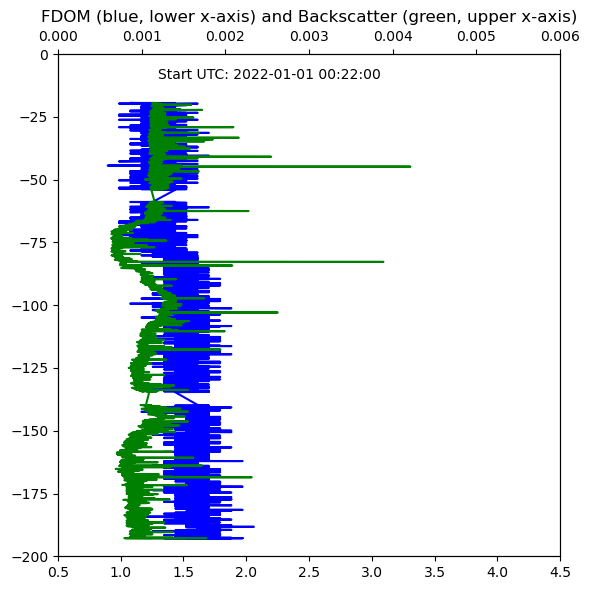

In [8]:
# fdom and backscatter
fig,axs = ChartTwoSensors(profiles, [ranges['fdom'], ranges['backscatter']], profile_list, 
                          d['fdom'][0],         -d['fdom'][1],        'FDOM', colors['do'], 'ascent',
                          d['backscatter'][0],  -d['backscatter'][1], 'Backscatter', colors['chlora'], 'ascent', 6, 6)

Attempting 4 charts



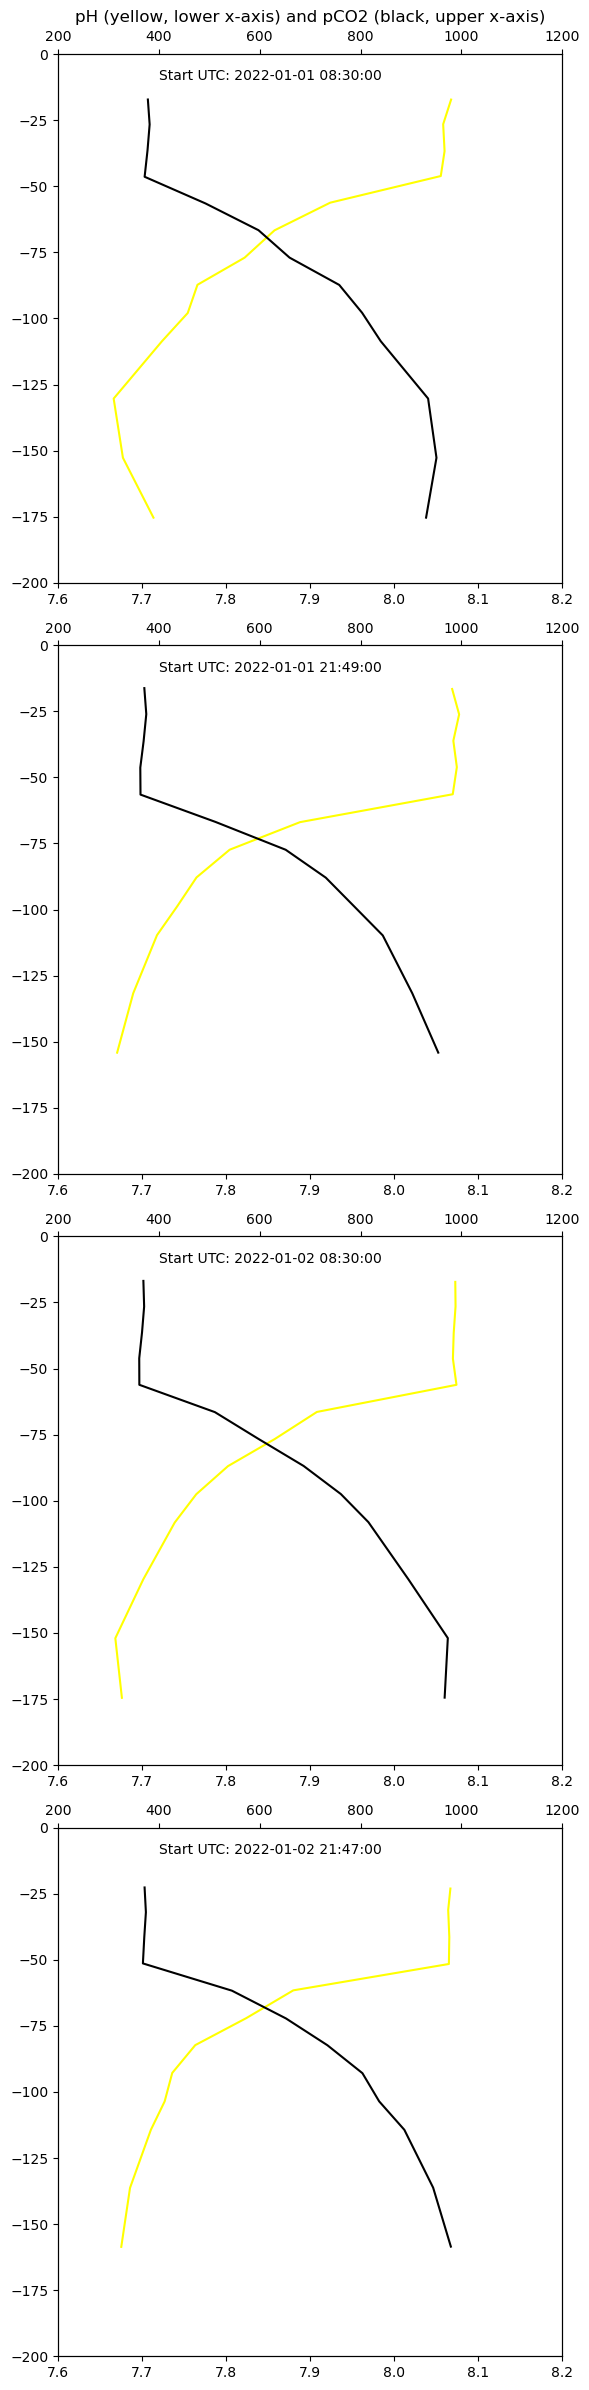

In [9]:
# pH and pCO2
# Notice that pH and pCO2 are measured only on midnight and noon *descents*
#   Profile 3 is the first midnight profile, 8 the first noon (but labels need fixing)
fig,axs = ChartTwoSensors(profiles, [ranges['ph'], ranges['pco2']], [3, 8, 12, 17],
                          d['ph'][0],    -d['ph'][1], 'pH', colors['ph'], 'descent',
                          d['pco2'][0],  -d['pco2'][1], 'pCO2', colors['pco2'], 'descent', 6, 6)

In [10]:
if False:
    # Two good representatives of noon spectral irradiance
    fig,axs = ChartTwoSensors(profiles, [ranges['spkir412nm'], ranges['spkir555nm']], [8, 80],
                              d['spkir412nm'][0], d['spkir412nm'][1], '412nm', colors['spkir412nm'], 'ascent',
                              d['spkir555nm'][0], d['spkir555nm'][1], '555nm', colors['spkir555nm'], 'ascent', 6, 4)


In [11]:
if False:
    # PAR and longer-wavelength spectral irradiance (not a very strong signal; see above)
    fig,axs = ChartTwoSensors(profiles, [ranges['par'], ranges['spkir620nm']], [8, 80],
                              d['par'][0], d['par'][1], 'PAR', colors['par'], 'ascent',
                              d['spkir620nm'][0], d['spkir620nm'][1], 'spkir620nm spkir', 
                              colors['spkir620nm'], 'ascent', 6, 4)

Attempting 4 charts



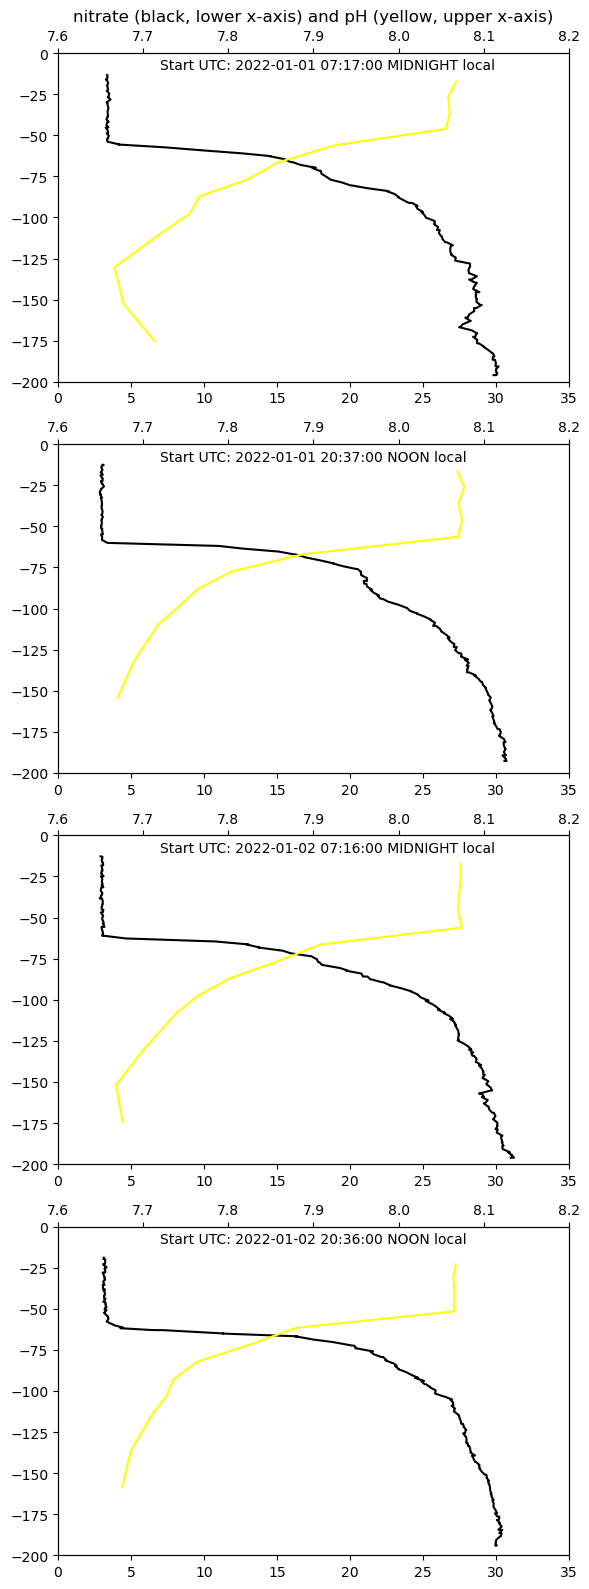

In [12]:
# Nitrate and current velocity 'up' (midnight and noon: ascent for nitrate)
fig,axs = ChartTwoSensors(profiles, [ranges['nitrate'], ranges['ph']], [3, 8, 12, 17],
                          d['nitrate'][0], -d['nitrate'][1], 'nitrate', colors['nitrate'], 'ascent',
                          d['ph'][0], -d['ph'][1], 'pH', colors['ph'], 'descent', 6, 4)

Attempting 1 charts



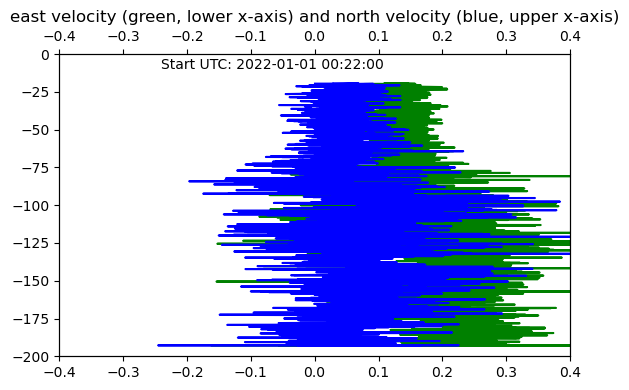

In [13]:
# Current velocity 'east' and 'north'
fig,axs = ChartTwoSensors(profiles, [ranges['east'], ranges['north']], [0],
                          d['east'][0], -d['east'][1], 'east velocity', colors['east'], 'ascent',
                          d['north'][0], -d['north'][1], 'north velocity', colors['north'], 'ascent', 6, 4)

## Another visualization: bundle charts


The 'depth-signal' charts above illustrate epipelagic snapshots in terms of single profiles. 
A next logical step is to create 'bundle charts' from consecutive profiles for a given sensor.
This introduces a sense of variability across a longer time interval. Again we note that 
nine consecutive profiles correspond to a single day. 


In [14]:
if False: ShowStaticBundles(d, profiles)   # broken

```def BundleChart(profiles, date0, date1, time0, time1, wid, hgt, data, title):
    '''
    Create a bundle chart: Multiple profiles showing sensor/depth in ensemble.
        date0   start / end of time range: date only, range is inclusive [date0, date1]
        date1
        time0   start / end time range for each day
        time1       (this scheme permits selecting midnight or noon)
        wid     figure size
        hgt
        data    a value from the data dictionary (5-tuple: includes range and color)
        title   chart title
BundleChart(profiles, dt64('2022-01-01'), dt64('2022-02-01'), td64(0, 'h'), td64(24, 'h'), 8, 6,  'Dissolved Oxygen')
```

<Axes: title={'center': 'Dissolved Oxygen'}>

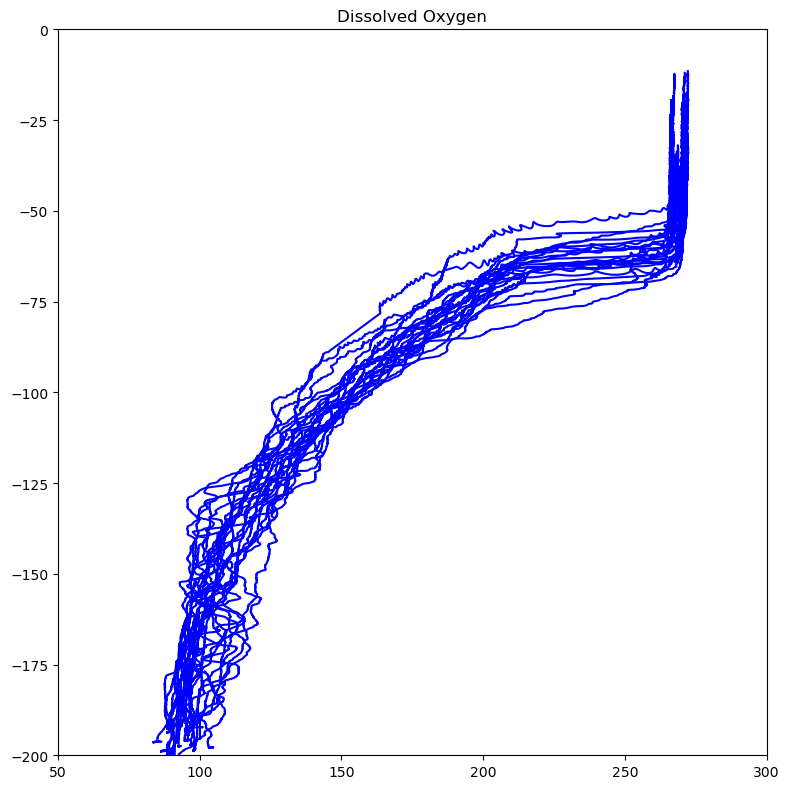

In [15]:
def LocalGenerateTimeWindowIndices(profiles, dt0, dt1):
    '''
    In UTC: Passed a time window via two bounding datetimes. Return a list of 
    profile indices for profiles that begin ascent within this time box. These 
    indices are rows in the profiles DataFrame.
    '''
    pidcs = []
    for i in range(len(profiles)):
        a0 = profiles["a0t"][i]
        if a0 >= dt0 and a0 <= dt1: pidcs.append(i)
    return pidcs


def LocalBundleChart(profiles, dt0, dt1, wid, hgt, data, depth, lo, hi, title, color):
    pidcs = LocalGenerateTimeWindowIndices(profiles, dt0, dt1)
    if len(pidcs) < 1: 
        print('LocalBundleChart(): Zero profile hits')
        return False
    fig, ax = plt.subplots(figsize=(wid, hgt), tight_layout=True)
    for i in range(len(pidcs)):
        ta0, ta1 = profiles["a0t"][pidcs[i]], profiles["a1t"][pidcs[i]]
        ax.plot(data.sel(time=slice(ta0,  ta1)), depth.sel(time=slice(ta0, ta1)), ms = 4., color=color)
    ax.set(title = title)
    ax.set(xlim = (lo, hi), ylim = (-200, 0))
    return ax

bundle_start_time, bundle_end_time = dt64('2022-01-01T00:00:00'), dt64('2022-01-04T00:00:00')
LocalBundleChart(profiles, bundle_start_time, bundle_end_time, 
                 8, 8, d['do'][0], -d['do'][1], d['do'][2], d['do'][3], 'Dissolved Oxygen', d['do'][4])

<Axes: title={'center': 'Dissolved Oxygen'}>

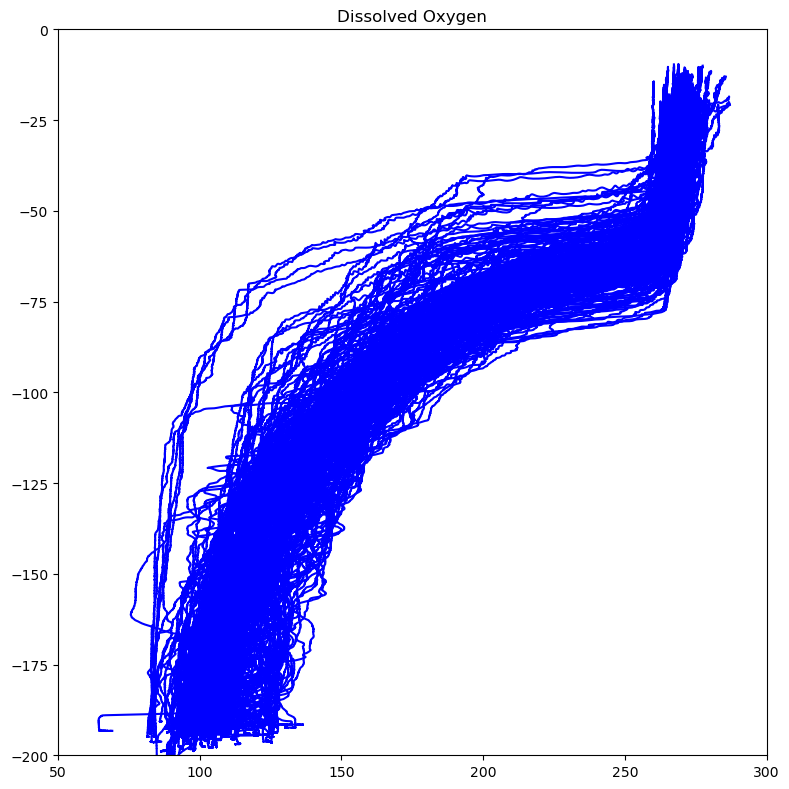

In [16]:
bundle_start_time, bundle_end_time = dt64('2022-01-01T00:00:00'), dt64('2022-02-01T00:00:00')
LocalBundleChart(profiles, bundle_start_time, bundle_end_time, 
                 8, 8, d['do'][0], -d['do'][1], d['do'][2], d['do'][3], 'Dissolved Oxygen', d['do'][4])

**Interpretation** The mixed layer varies in depth from 40 to 80 meters. The standard hypothesis 
is this corresponds to surface winds driving waves and hence mixing. 


There are anomalies in the month-long dataset: Dissolved oxygen excursions below the main 'bundle'. 
In particular four 'low oxygen' profiles originate in the pycnocline and extend down to the platform 
depth at 190 meters. To verify that these profiles are consecutive we need a convenient scrolling
interface; which we now introduce by means of an interactive 'widget'.

In [17]:
from ipywidgets import interact, widgets
from traitlets import dlink

In [18]:
def BundleInteract(sensor_key, time_index, bundle_size):
    '''
    Consider a time range that includes many (e.g. 279) consecutive profiles. This function plots sensor data
    within the time range. Choose the sensor using a dropdown. Choose the first profile using the start slider.
    Choose the number of consecutive profiles to chart using the bundle slider. 
    Details
      - There is no support at this time for selecting midnight or noon profiles exclusively
          - nitrate, ph and pco2 bundle charts will be correspondingly sparse
      - There is a little bit of intelligence built in to the selection of ascent or descent
          - most sensors measure on ascent or ascent + descent. pco2 and ph are descent only
          - ph and pco2 still have a charting bug "last-to-first line" clutter: For some reason
            the first profile value is the last value from the prior profile. There is a hack in
            place ("i0") to deal with this.
      - All available profiles are first plotted in light grey
          - This tacitly assumes a month or less time interval for the current full dataset
    '''
    
    
    (phase0, phase1, i0) = ('a0t', 'a1t', 0) if not (sensor_key == 'ph' or sensor_key == 'pco2') else ('d0t', 'd1t', 1)
    x    = d[sensor_key][0]
    z    = d[sensor_key][1]
    xlo = d[sensor_key][2]
    xhi = d[sensor_key][3]
    xtitle = sensor_names[sensor_key]
    xcolor = d[sensor_key][4]

    # This configuration code block is hardcoded to work with Jan 2022
    date0, date1   = dt64('2022-01-01T00:00:00'), dt64('2022-02-01T00:00:00')
    wid, hgt       = 9, 6
    x0, x1, z0, z1 = xlo, xhi, -200, 0
    title          = xtitle
    color          = xcolor
    pidcs          = LocalGenerateTimeWindowIndices(profiles, date0, date1)    # !!!!! either midn or noon, not both
    nProfiles      = len(pidcs)
    
    fig, ax = plt.subplots(figsize=(wid, hgt), tight_layout=True)
    
    # insert code: light grey full history
    iProf0 = 0
    iProf1 = nProfiles
    for i in range(iProf0, iProf1):
        pIdx = pidcs[i]
        ta0, ta1 = profiles[phase0][pIdx], profiles[phase1][pIdx]
        xi, zi = x.sel(time=slice(ta0,  ta1)), -z.sel(time=slice(ta0, ta1))
        ax.plot(xi[i0:], zi[i0:], ms = 4., color = 'xkcd:light grey')    
    
    # resume normal code
    iProf0 = time_index if time_index < nProfiles else nProfiles
    iProf1 = iProf0 + bundle_size if iProf0 + bundle_size < nProfiles else nProfiles
    for i in range(iProf0, iProf1):
        pIdx = pidcs[i]
        ta0, ta1 = profiles[phase0][pIdx], profiles[phase1][pIdx]
        xi, zi = x.sel(time=slice(ta0,  ta1)), -z.sel(time=slice(ta0, ta1))
        ax.plot(xi[i0:], zi[i0:], ms = 4., color=color, mfc=color)
    ax.set(title = title)
    ax.set(xlim = (x0, x1), ylim = (z0, z1))

    # Add text indicating the current time range of the profile bundle
    # tString = str(p["ascent_start"][pIdcs[iProf0]])
    # if iProf1 - iProf0 > 1: tString += '\n ...through... \n' + str(p["ascent_start"][pIdcs[iProf1-1]])
    # ax.text(px, py, tString)
    
    plt.show()
    return

In [19]:
def Interactor(continuous_update = False):
    '''Set up three bundle-interactive charts, vertically. Independent sliders for choice of 
    sensor, starting profile by index, and number of profiles in bundle. (90 profiles is about
    ten days.) A fast machine can have cu = True to give a slider-responsive animation. Make
    it False to avoid jerky 'takes forever' animation on less powerful machines.
    '''
    style = {'description_width': 'initial'}
    
    # data dictionary d{} keys:
    optionsList = ['temp', 'salinity', 'density', 'conductivity', 'do', 'chlora', 'fdom', 'bb', 'pco2', \
                   'ph', 'par', 'nitrate', 'east', 'north', 'up']

    interact(BundleInteract, \
                             sensor_key = widgets.Dropdown(options=optionsList,  value=optionsList[0], description='sensor'), \
                             time_index = widgets.IntSlider(min=0, max=270, step=1, value=160,                    \
                                                            layout=widgets.Layout(width='35%'),                   \
                                                            continuous_update=False, description='bundle start',  \
                                                            style=style),
                             bundle_size = widgets.IntSlider(min=1, max=90, step=1, value=20,                     \
                                                            layout=widgets.Layout(width='35%'),                   \
                                                            continuous_update=False, description='bundle width',  \
                                                            style=style))

    return

Interactor(False)

interactive(children=(Dropdown(description='sensor', options=('temp', 'salinity', 'density', 'conductivity', '…

### **Interpretation**


Selecting dissolved oxygen (**`do`**) with `start = 0`, `width = 90` shows two anomalies, 
both *low* oxygen levels. The full bundle is shown in light grey in the background for context.
Narrowing in we get `start = 59` and `width = 4` showing four consecutive
anomalous profiles. The anomaly extends as far down as the profiler platform at ~195 meters.


The bundle width slider can be maximized to reinforce the 
typical (bundle-based) profile distribution in relation to the second anomaly. 


Incidentally other anomalies are also apparent, for example a single outlier in profile 211.


***Temperature coincidence***: An obvious next thought is to check for *coincidence*: This dissolved oxygen anomaly 
with other sensors.  Beginning with temperature: During the anomaly the mixed layer is apparently very small (30 meters) 
with a relatively cold upper water column temperature. Sub-pycnocline temperatures are in contrast comparatively warm. 
The pycnocline itself is very constricted and features temperature inversions.


***Salinity coincidence***: The anomaly is again present, with a shallow fixed layer and comparatively 
high salinity throughout the profiler depth range. 


***Density coincidence***: Sharp increase through the pycnocline, anomalously high.


***Other coincidences***: pH, pCO2, nitrate, chlorophyll: All anomalous, respectively low, high, high, low.

In [20]:
Interactor(False)
Interactor(False)
Interactor(False)

interactive(children=(Dropdown(description='sensor', options=('temp', 'salinity', 'density', 'conductivity', '…

interactive(children=(Dropdown(description='sensor', options=('temp', 'salinity', 'density', 'conductivity', '…

interactive(children=(Dropdown(description='sensor', options=('temp', 'salinity', 'density', 'conductivity', '…

In [21]:
ZuluToLocal = td64(8, 'h')
for i in range(4): print(profiles['a0t'][59+i]-ZuluToLocal)

2022-01-07 05:27:00
2022-01-07 07:42:00
2022-01-07 10:07:00
2022-01-07 12:37:00


Summary: The OSB shallow profiler observed a mass of acidic, nutrient rich water with depleted oxygen 
and elevated carbon dioxide on January 7 2022. The episode lasted ten hours.


Questions about the sea state
- What was the current before / during / after this anomaly?
- Was the onset sharp or gradual? Decay to typical sharp or gradual?
- What was the windspeed? Wave height? 

The NOAA **National Data Buoy Center** (NDBC) has historical data available for download.
[This website](https://www.ndbc.noaa.gov/histsearch.php) is the search interface. Stations 
46098 and 46050 are closest to the Oregon Slope Base observing site: Respective distances
are 1 km and 46 km. Datasets are downloadable
as text files (space delimiter). No-data values typically have nines in them, as `999` 
or `99.00` or `999.0`. Observations are at 10 minute intervals.  


### Historical buoy data: Metadata


The first two rows of a data file are column headers: Type and units. An interpretive 
key may be found [here](https://www.ndbc.noaa.gov/faq/measdes.shtml). For the two stations
of interest, 46098 and 46050, year = 2022, we have these column headers:

```
YY  MM DD hh mm     Time down to minutes: UTC not local
WDIR WSPD GST       Wind speed, direction and gusts; direction is degrees clockwise from true north
WVHT                Wave height, meters
DPD   APD           Dominant and Average wave period
MWD                 Mean wave direction (direction from which; deg CW from TN as above)
PRES                Sea surface atmospheric pressure (hPa, hectoPascale or equiv. millibars)
ATMP                Air temperature (deg C)
WTMP                Surface water temperature (deg C)
DEWP                Dewpoint (deg C)
VIS                 Visibility (mi)
TIDE                Tide (ft)
```

### Locations, proximity


```
Oregon Slope Base:  44.37415 N      124.95648 W
Buoy 46050:         44.669   N      124.546   W       Distance to OSB: 46km
Buoy 46098:         44.378   N      124.947   W       Distance to OSB:  1km
```

In [26]:
# This cell calculates distances from NDBC buoys to the OSB shallow profiler

from math import cos, pi, sqrt

loc_osb_lat, loc_osb_lon               = 44.37415, -124.95648
loc_buoy_46050_lat, loc_buoy_46050_lon = 44.669,   -124.546
loc_buoy_46098_lat, loc_buoy_46098_lon = 44.378,   -124.947

earth_r   = 6378000
earth_c   = earth_r * 2 * pi
deg_lat_m = earth_c / 360

print('one degree of latitude approximately', round(deg_lat_m, 1), 'meters')

meanlat    = (1/3)*(loc_osb_lat + loc_buoy_46050_lat + loc_buoy_46098_lat)
dtr        = pi/180
lon_stride = deg_lat_m * cos(meanlat*dtr)

print('At this latitude one degree of longitude is', round(lon_stride, 1), 'meters')

dlat = loc_osb_lat - loc_buoy_46050_lat
dlon = loc_osb_lon - loc_buoy_46050_lon
d_osb_46050 = sqrt((dlat*deg_lat_m)**2 + (dlon*lon_stride)**2)

dlat = loc_osb_lat - loc_buoy_46098_lat
dlon = loc_osb_lon - loc_buoy_46098_lon
d_osb_46098 = sqrt((dlat*deg_lat_m)**2 + (dlon*lon_stride)**2)

print('Distance OSB to buoy 46050:', round(d_osb_46050, 1), 'm')
print('Distance OSB to buoy 46098:', round(d_osb_46098, 1), 'm')

one degree of latitude approximately 111317.1 meters
At this latitude one degree of longitude is 79432.8 meters
Distance OSB to buoy 46050: 46264.4 m
Distance OSB to buoy 46098: 866.4 m


In [27]:
# This cell reads in the 46098 (proximal) data to a pandas DataFrame
ndbc_root_path     = './data/noaa/ndbc/'
buoy_id            = '46098'
year               = '2022'
ndbc_filename      = 'station_' + buoy_id + '_year_' + year + '.txt'
ndbc_path          = ndbc_root_path + ndbc_filename

### Resampling profiles to depth bins

We have d['sensor'][0] and [1] as respectively sensor and depth DataArrays, with dimension/coordinate = time.
That is, both sensor data and depth data are indexed by time of observation. However we are treating each profile
like a snapshot of the water column; so time is not the key index. Rather this is depth; so we now bin the
data on some vertical spatial interval. 

Practically this means a single profile will be a Dataset with dimension/coordinate `depth` at some spatial 
scale, e.g. 20 cm. Time will be dropped. We will bin both using mean and standard deviation.


***Note: .resample() only operates on a time dimension. Please document: c.resample( --not time-- ) fails***

In [30]:
def GenerateProfileFromTimeSeries(a, b, t0, t1, sensor):
    a_sel, b_sel = a.sel(time=slice(t0,  t1)), b.sel(time=slice(t0, t1))
    c = xr.combine_by_coords([a_sel, b_sel])
    c = c.swap_dims({'time':'depth'})
    c = c.drop_vars('time')
    c = c.sortby('depth')
    depth_bounds = np.linspace(0., 200, 1001)             # 1001 bounds: 0., .20, ..., 200.
    depth_centers = np.linspace(0.10, 199.9, 1000)
    cmean = c.groupby_bins('depth', depth_bounds, labels=depth_centers).mean()
    cstd  = c.groupby_bins('depth', depth_bounds, labels=depth_centers).std()
    cmean = cmean.rename({sensor: sensor + '_mean'})
    cstd  = cstd.rename({sensor: sensor + '_std'})
    c = xr.combine_by_coords([cmean, cstd])
    return c

c = GenerateProfileFromTimeSeries(d['do'][0], d['do'][1], profiles["a0t"][59], profiles["a1t"][59], 'do')

In [31]:
# ChartSensorMeanStd(s, km, ks, kz, rm, rs, colorm, colors, wid, len, timelabel = ''):


AttributeError: 'Dataset' object has no attribute 'km'

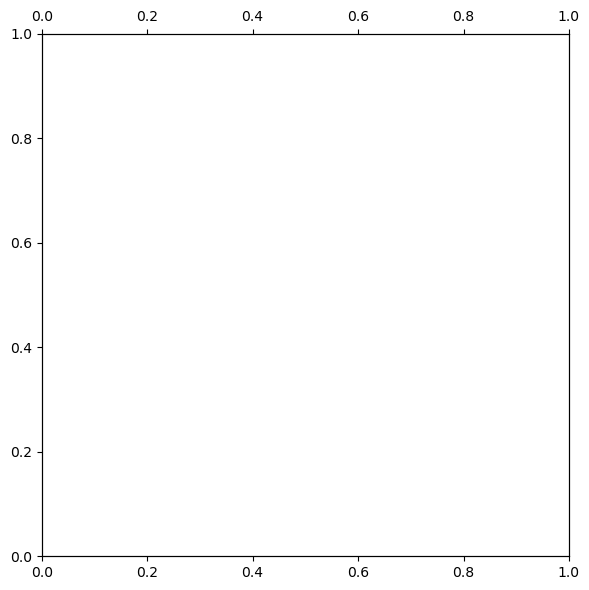

In [32]:
fig, ax = ChartSensorMeanStd(c, 'do_mean', 'do_std', 'depth_bin', [50, 400.], [0., 7.], 'blue', 'red', 6, 6)

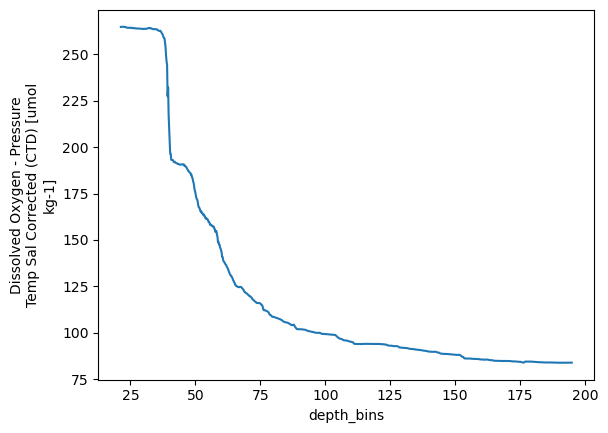

In [33]:
c.do_mean.plot()

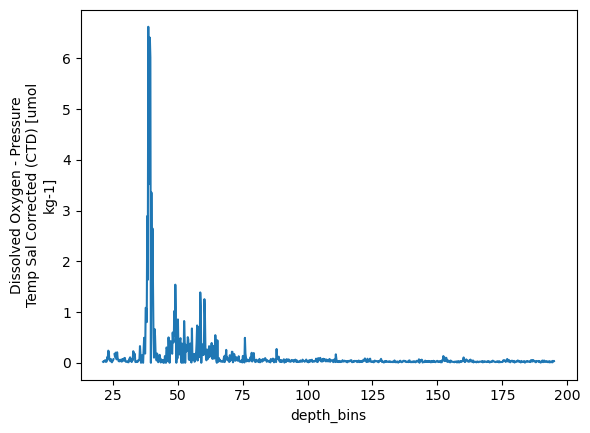

In [34]:
c.do_std.plot()

In [ ]:
# temperature and salinity
do_std = [0., 7.]
fig,axs = ChartSensorMeanStd([ranges['do'], do_std],
                          c['do_mean'], -c['depth_bins'], 'Dissolved Oxygen',   'blue', 'ascent',
                          c['do_std'],  -c['depth_bins'], 'Standard Deviation', 'red',  'ascent', 8, 8)

## Concept material

The charts below place two sensors x 3 across for a total of six. 

```{figure} ../img/ABCOST_signals_vs_depth_and_time.png
---
height: 500px
name: directive-fig
---
Salinity, Temperature, Dissolved Oxygen and Bio-optical signals with depth
```
    

In [ ]:
from IPython.display import HTML, Video
Video('./../img/multisensor_animation.mp4', embed=True, width = 500, height = 500)

### MODIS surface chlorophyll


```{figure} ../img/modis_chlorophyll.png
---
height: 500px
name: directive-fig
---
Ocean surface chlorophyll inferred from MODIS satellite images
```